## Initialization

In [1]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib
import matplotlib.pyplot as plt
from torch.distributions.constraints import positive

import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import pyro
import ssms
import lanfactory
torch.set_default_dtype(torch.float64)

from lanfactory.trainers.torch_mlp import TorchMLP 

import lanfactory
import ssms

In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(9)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

## Make Hierarchical Gaussian Data

In [3]:
import scipy
n_subjects = 20
subj_gauss_scale = 0.1

global_mean_mean = 0 #scipy.stats.norm.rvs(loc = 0, scale = 0.5)
global_mean_std = 0.25 #scipy.stats.halfnorm.rvs(loc = 0, scale = 1)
#global_std_std = scipy.stats.halfnorm.rvs(loc = 10, scale = 10)

#subj_mean = scipy.stats.norm.rvs(loc = global_mean_mean, scale = global_mean_std, size = 10)
subj_mean = scipy.stats.norm.rvs(loc = global_mean_mean, scale = global_mean_std, size = n_subjects)
#data = scipy.stats.norm.rvs(loc = subj_mean, scale = subj_std, size = (1000, 10))
#data = scipy.stats.norm.rvs(loc = subj_mean, scale = 10, size = (1000, 10)).transpose()
data = scipy.stats.norm.rvs(loc = subj_mean, scale = subj_gauss_scale, size = (1000, n_subjects))

In [4]:
data.shape

(1000, 20)

In [5]:
n_subjects
data_dict = {'n_subjects': n_subjects,
             'subj_gauss_scale': subj_gauss_scale,
             'global_mean_mean': global_mean_mean,
             'global_mean_std': global_mean_std,
             'subj_mean': subj_mean,
             'data': data}

pickle.dump(data_dict, open('pyro_data.pickle', 'wb'))

In [6]:
data_dict = pickle.load(open('pyro_data.pickle', 'rb'))

n_subjects = data_dict['n_subjects']
subj_gauss_scale = data_dict['subj_gauss_scale']
global_mean_mean = data_dict['global_mean_mean']
global_mean_std = data_dict['global_mean_std']
subj_mean = data_dict['subj_mean']
data = data_dict['data']

In [7]:
data_dict

{'n_subjects': 20,
 'subj_gauss_scale': 0.1,
 'global_mean_mean': 0,
 'global_mean_std': 0.25,
 'subj_mean': array([ 2.77138678e-04, -7.23860173e-02, -2.79016576e-01, -3.22068919e-03,
        -9.45903661e-02, -1.20283841e-01, -3.79332795e-01, -1.22717995e-01,
        -6.01701446e-02, -1.61986865e-01,  1.58972770e-01,  4.35029326e-01,
         7.41705544e-02,  1.76875915e-01,  4.55703941e-01,  1.07692257e-01,
         3.85682406e-01, -2.25180293e-01, -3.42812526e-02,  3.24394753e-01]),
 'data': array([[ 0.06780426, -0.06919021, -0.18720199, ..., -0.12094055,
          0.09609979,  0.46333483],
        [-0.06536812, -0.07801175, -0.32900684, ..., -0.29135096,
          0.04265359,  0.23449426],
        [ 0.16964093, -0.24211954, -0.5583536 , ..., -0.22515813,
          0.03210425,  0.39934285],
        ...,
        [-0.04002978, -0.21687662, -0.37494574, ..., -0.37282682,
         -0.07650217,  0.28450335],
        [-0.05165106,  0.0215559 , -0.28576524, ..., -0.3625508 ,
         -0.221

In [7]:
np.save('pyro_data', data)

In [8]:
data = np.load('pyro_data.npy')
n_subjects = data.shape[1]

(array([ 10.,  33., 106., 203., 251., 221., 115.,  40.,  20.,   1.]),
 array([-0.28857675, -0.22547509, -0.16237343, -0.09927178, -0.03617012,
         0.02693154,  0.0900332 ,  0.15313485,  0.21623651,  0.27933817,
         0.34243983]),
 <BarContainer object of 10 artists>)

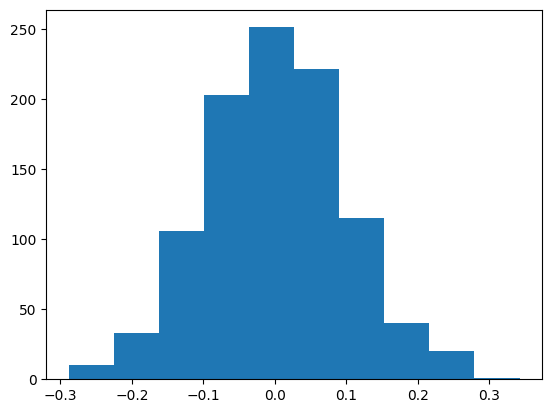

In [9]:
plt.hist(data[:, 0])

(array([ 13.,  47., 111., 220., 235., 199., 102.,  59.,  11.,   3.]),
 array([-0.35073323, -0.2886371 , -0.22654096, -0.16444482, -0.10234869,
        -0.04025255,  0.02184359,  0.08393972,  0.14603586,  0.20813199,
         0.27022813]),
 <BarContainer object of 10 artists>)

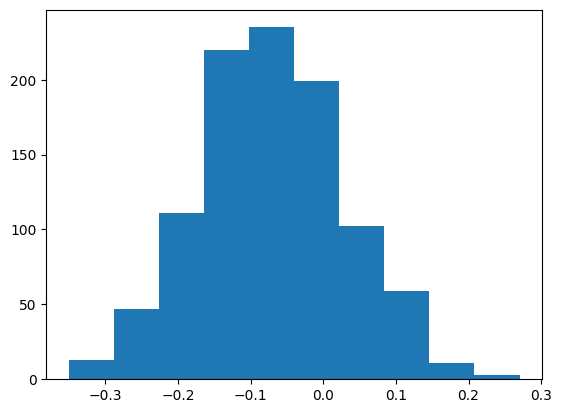

In [10]:
plt.hist(data[:, 1])

In [11]:
# import scipy
# n_subjects = 20
# global_mean_mean = scipy.stats.norm.rvs(loc = 0, scale = 10)
# global_mean_std = scipy.stats.halfnorm.rvs(loc = 0, scale = 10)
# #global_std_std = scipy.stats.halfnorm.rvs(loc = 10, scale = 10)

# #subj_mean = scipy.stats.norm.rvs(loc = global_mean_mean, scale = global_mean_std, size = 10)
# subj_mean = scipy.stats.norm.rvs(loc = global_mean_mean, scale = global_mean_std, size = n_subjects)
# #data = scipy.stats.norm.rvs(loc = subj_mean, scale = subj_std, size = (1000, 10))
# #data = scipy.stats.norm.rvs(loc = subj_mean, scale = 10, size = (1000, 10)).transpose()
# data_2 = scipy.stats.norm.rvs(loc = subj_mean, scale = 10, size = (1000, 2, n_subjects))

## Define Custom Gaussian Distribution

In [8]:
import math
from numbers import Real
from numbers import Number

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

class MyGaussian(dist.ExponentialFamily):
    r"""
    Creates a normal (also called Gaussian) distribution parameterized by
    :attr:`loc` and :attr:`scale`.
    Example::
        >>> m = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        >>> m.sample()  # normally distributed with loc=0 and scale=1
        tensor([ 0.1046])
    Args:
        loc (float or Tensor): mean of the distribution (often referred to as mu)
        scale (float or Tensor): standard deviation of the distribution
            (often referred to as sigma)
    """
    arg_constraints = {'loc': constraints.real, 'scale': constraints.positive}
    support = constraints.real
    has_rsample = True
    _mean_carrier_measure = 0
    
    @property
    def _natural_params(self):
        return (self.loc / self.scale.pow(2), -0.5 * self.scale.pow(2).reciprocal())

    @property
    def mean(self):
        return self.loc

    @property
    def stddev(self):
        return self.scale

    @property
    def variance(self):
        return self.stddev.pow(2)

    def __init__(self, loc, scale, validate_args=None):
        self.loc, self.scale = broadcast_all(loc, scale)
        if isinstance(loc, Number) and isinstance(scale, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
            print('batch_shape: ')
            print(batch_shape)
        super(MyGaussian, self).__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(MyGaussian, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        super(MyGaussian, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def sample(self, sample_shape=torch.Size()):
        print('evaluated sample')
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            return torch.normal(self.loc.expand(shape), self.scale.expand(shape))

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        return self.loc + eps * self.scale

    def log_prob(self, value):
        #print('evaluated log_prob')
        if self._validate_args:
            self._validate_sample(value)
        # compute the variance
        var = (self.scale ** 2)
        log_scale = math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
        print(log_scale)
        return -((value - self.loc) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return 0.5 * (1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2)))

    def icdf(self, value):
        return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)

    def entropy(self):
        return 0.5 + 0.5 * math.log(2 * math.pi) + torch.log(self.scale)

    def _log_normalizer(self, x, y):
        return -0.25 * x.pow(2) / y + 0.5 * torch.log(-math.pi / y)

In [9]:
import math
from numbers import Real
from numbers import Number

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

class MyNewGaussian(dist.TorchDistribution):
#     arg_constraints = {'loc': constraints.interval(-1, 1),
#                        'scale': constraints.interval(0.0001, 10)
#                       }
    
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale
        self.log_prob_fixed_term = math.log(math.sqrt(2 * math.pi))
        if isinstance(loc, Number) and isinstance(scale, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        
        print('batch_shape: ')
        print(batch_shape)
        
        print('event_shape: ')
        print(torch.Size())
        
        super().__init__(batch_shape = batch_shape, event_shape = torch.Size()) # event_shape = (1,))
        
    def sample(self):
        return torch.tensor(np.random.normal(0,1))
    
    def log_prob(self, value):
        #print('passing through log_prob')
        print('value size')
        print(value.size())
        print('loce size')
        print(self.loc.size())
        
        
        print('batch size internal: ')
        print(self.batch_shape)
        
        print('event_shape: ')
        print(self.event_shape)
        # compute the variance
        var = (self.scale ** 2)
        log_scale = self.scale.log()
        #log_scale = math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
        log_prob = -((value - self.loc) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))
        #print(log_prob.size())
        
        #print(log_prob.size())
        #print(self.loc.size())
        
        log_prob = torch.where((self.loc < -1) | (self.loc > 1), torch.zeros_like(log_prob) - 16.11809, log_prob)
        #log_prob[:, self.loc < -1] = -16.11809
        #log_prob[:, self.loc >= 1] = -16.11809
        print('log_prob shape')
        print(log_prob.size())
        return log_prob
    
    
#out = torch.where(scale > 0.5, torch.zeros_like(log_prob), log_prob)

In [14]:
x = MyNewGaussian(torch.tensor([1.0]), torch.tensor([1.0]))

batch_shape: 
torch.Size([1])
event_shape: 
torch.Size([])


/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.MyNewGaussian'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


In [15]:
x.event_shape

torch.Size([])

In [91]:
# import pyro.distributions as dist
# import pyro.distributions.constraints as constraints

# def basic_hierarchical_model_2(num_subjects, num_trials, data):
#     g_mu_mu = pyro.sample("g_mu_mu", dist.Normal(0., 100.))
#     g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
#     #g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
#     #g_std_mu = pyro.sample("g_std_mu", dist.HalfNormal(100.))
#     #g_std_std = pyro.sample("g_std_std", dist.HalfNormal(100.))
    
#     with pyro.plate("subjects", num_subjects) as subjects_plate:
#         #subj_mu = pyro.sample("subj_mu", dist.Normal(g_mu_mu, g_mu_std))
#         subj_mu = pyro.sample("subj_mu", dist.Normal(torch.tensor([g_mu_mu, g_mu_mu]), g_mu_std))
#         #subj_std = pyro.sample("subj_std", dist.LogNormal(g_std_mu, g_std_std))
#         with pyro.plate("data", num_trials) as data_plate:
#             return pyro.sample("obs", dist.Normal(subj_mu, torch.tensor(10)), obs = data)

In [16]:
def basic_gaussian_model(num_trials, data):
    mu = pyro.sample("mu", dist.Normal(0., 100.))
    sigma = pyro.sample("sigma", dist.HalfNormal(100.))
    
    with pyro.plate("data", num_trials) as data_plate:
        return pyro.sample("obs", dist.Normal(mu, sigma), obs = data)

In [36]:
# import pyro.distributions as dist
# import pyro.distributions.constraints as constraints

# def basic_hierarchical_model(num_subjects, num_trials, data):
#     g_mu_mu = pyro.sample("g_mu_mu", dist.Normal(0., 100.))
#     g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
#     #g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
#     #g_std_mu = pyro.sample("g_std_mu", dist.HalfNormal(100.))
#     #g_std_std = pyro.sample("g_std_std", dist.HalfNormal(100.))
    
#     with pyro.plate("subjects", num_subjects) as subjects_plate:
#         subj_mu = pyro.sample("subj_mu", dist.Normal(g_mu_mu, g_mu_std))
#         #subj_std = pyro.sample("subj_std", dist.LogNormal(g_std_mu, g_std_std))
#         with pyro.plate("data", num_trials) as data_plate:
#             return pyro.sample("obs", MyNewGaussian(subj_mu, torch.tensor(0.1)), obs = data)

In [10]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def basic_hierarchical_model(num_subjects, num_trials, data):
    g_mu_mu = pyro.sample("g_mu_mu", dist.Normal(0., 100.))
    g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
    #g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
    #g_std_mu = pyro.sample("g_std_mu", dist.HalfNormal(100.))
    #g_std_std = pyro.sample("g_std_std", dist.HalfNormal(100.))
    
    with pyro.plate("subjects", num_subjects) as subjects_plate:
        subj_mu = pyro.sample("subj_mu", dist.Normal(g_mu_mu, g_mu_std))
        #subj_std = pyro.sample("subj_std", dist.LogNormal(g_std_mu, g_std_std))
        with pyro.plate("data", num_trials) as data_plate:
            return pyro.sample("obs", MyGaussian(subj_mu, torch.tensor(0.1)), obs = data)

In [26]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def basic_hierarchical_model(num_subjects, num_trials, data):
    g_mu_mu = pyro.sample("g_mu_mu", dist.Normal(0., 100.))
    g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
    #g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
    #g_std_mu = pyro.sample("g_std_mu", dist.HalfNormal(100.))
    #g_std_std = pyro.sample("g_std_std", dist.HalfNormal(100.))
    
    with pyro.plate("subjects", num_subjects) as subjects_plate:
        subj_mu = pyro.sample("subj_mu", dist.Normal(g_mu_mu, g_mu_std))
        #subj_std = pyro.sample("subj_std", dist.LogNormal(g_std_mu, g_std_std))
        with pyro.plate("data", num_trials) as data_plate:
            return pyro.sample("obs", dist.Normal(subj_mu, torch.tensor(10)), obs = data)

In [10]:
def custom_guide(num_subjects, num_trials, data):
    g_mu_mu_loc = pyro.param('g_mu_mu_loc', lambda:torch.tensor(0.))
    g_mu_mu_scale = pyro.param('g_mu_mu_scale', lambda:torch.tensor(1.),
                              constraint = constraints.positive)
    
    g_mu_std_scale = pyro.param('g_mu_std_scale', lambda:torch.tensor(10.),
                                constraint = constraints.positive)
    g_mu_std_concentration = pyro.param('g_mu_std_concentration', lambda:torch.tensor(10.),
                              constraint = constraints.positive)
    
    subj_mu_loc = pyro.param('subj_mus', lambda:torch.randn(num_subjects))
    subj_mu_scale = pyro.param('subj_scales', lambda:torch.ones(num_subjects),
                               constraint = constraints.positive)
    
    g_mu_mu = pyro.sample("g_mu_mu", dist.Normal(g_mu_mu_loc, g_mu_mu_scale))
    g_mu_std = pyro.sample("g_mu_std", dist.Gamma(g_mu_std_concentration, 1 / g_mu_std_scale))
    
    with pyro.plate("subjects", num_subjects) as subjects_plate:
        subj_mu = pyro.sample("subj_mu", dist.Normal(subj_mu_loc, subj_mu_scale))
            
    return {"g_mu_mu": g_mu_mu, "g_mu_std": g_mu_std, "subj_mu": subj_mu}

In [19]:
# def custom_guide_2(num_subjects, num_trials, data):
#     g_mu_mu_loc = pyro.param('g_mu_mu_loc', lambda:torch.tensor(0.))
#     g_mu_mu_scale = pyro.param('g_mu_mu_scale', lambda:torch.tensor(1.),
#                               constraint = constraints.positive)
    
#     g_mu_std_scale = pyro.param('g_mu_std_scale', lambda:torch.tensor(10.),
#                                 constraint = constraints.positive)
#     g_mu_std_concentration = pyro.param('g_mu_std_concentration', lambda:torch.tensor(10.),
#                               constraint = constraints.positive)
    
#     subj_mu_loc = pyro.param('subj_mus', lambda:torch.randn(num_subjects))
#     subj_mu_scale = pyro.param('subj_scales', lambda:torch.ones(num_subjects),
#                                constraint = constraints.positive)
    
#     g_mu_mu = pyro.sample("g_mu_mu", dist.Normal(g_mu_mu_loc, g_mu_mu_scale))
#     g_mu_std = pyro.sample("g_mu_std", dist.Gamma(g_mu_std_concentration, 1 / g_mu_std_scale))
    
#     with pyro.plate("subjects", num_subjects) as subjects_plate:
#         subj_mu = pyro.sample("subj_mu", dist.Normal(torch.tensor([subj_mu_loc, subj_mu_loc]), subj_mu_scale))
            
#     return {"g_mu_mu": g_mu_mu, "g_mu_std": g_mu_std, "subj_mu": subj_mu}

In [24]:
# pyro.render_model(basic_hierarchical_model_2, model_args = (n_subjects, 1000, torch.tensor(data), ), 
#                   render_distributions = True, 
#                   render_params = True)

--Return--
None
> <ipython-input-14-c4dce4f2a142>(2)<module>()
      1 import ipdb
----> 2 ipdb.set_trace()
      3 pyro.render_model(basic_hierarchical_model, model_args = (n_subjects, 1000, torch.tensor(data), ), 



ipdb>  n


    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

    [... skipped 1 hidden frame]

> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3349)run_ast_nodes()
   3348 
-> 3349                 for node,mode in to_run:
   3350                     if mode == 'exec':



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3350)run_ast_nodes()
   3349                 for node,mode in to_run:
-> 3350                     if mode == 'exec':
   3351                         mod = Module([node], [])



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3352)run_ast_nodes()
   3351                         mod = Module([node], [])
-> 3352                     elif mode == 'single':
   3353                         mod = ast.Interactive([node])



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3353)run_ast_nodes()
   3352                     elif mode == 'single':
-> 3353                         mod = ast.Interactive([node])
   3354                     with compiler.extra_flags(getattr(ast, 'PyCF_ALLOW_TOP_LEVEL_AWAIT', 0x0) if self.autoawait else 0x0):



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3354)run_ast_nodes()
   3353                         mod = ast.Interactive([node])
-> 3354                     with compiler.extra_flags(getattr(ast, 'PyCF_ALLOW_TOP_LEVEL_AWAIT', 0x0) if self.autoawait else 0x0):
   3355                         code = compiler(mod, cell_name, mode)



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3355)run_ast_nodes()
   3354                     with compiler.extra_flags(getattr(ast, 'PyCF_ALLOW_TOP_LEVEL_AWAIT', 0x0) if self.autoawait else 0x0):
-> 3355                         code = compiler(mod, cell_name, mode)
   3356                         asy = compare(code)



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3356)run_ast_nodes()
   3355                         code = compiler(mod, cell_name, mode)
-> 3356                         asy = compare(code)
   3357                     if (await self.run_code(code, result,  async_=asy)):



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3357)run_ast_nodes()
   3356                         asy = compare(code)
-> 3357                     if (await self.run_code(code, result,  async_=asy)):
   3358                         return True



ipdb>  n


batch_shape: 
torch.Size([20])
Provenance:
frozenset({'subj_mu'})
Tensor:
tensor([[-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026],
        ...,
        [-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026]])
Provenance:
frozenset({'subj_mu'})
Tensor:
tensor([[-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026],
        ...,
        [-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026,  ..., -2.3026, -2.3026, -2.3026]])


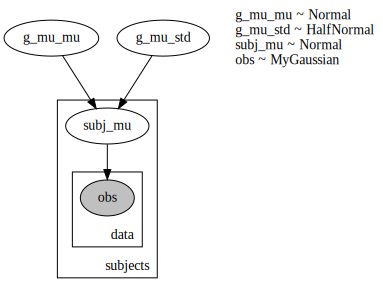

> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3349)run_ast_nodes()
   3348 
-> 3349                 for node,mode in to_run:
   3350                     if mode == 'exec':



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3361)run_ast_nodes()
   3360             # Flush softspace
-> 3361             if softspace(sys.stdout, 0):
   3362                 print()



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3379)run_ast_nodes()
   3378 
-> 3379         return False
   3380 



ipdb>  n


Internal StopIteration: False
> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3166)run_cell_async()
   3165                 has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
-> 3166                        interactivity=interactivity, compiler=compiler, result=result)
   3167 



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3168)run_cell_async()
   3167 
-> 3168                 self.last_execution_succeeded = not has_raised
   3169                 self.last_execution_result = result



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3169)run_cell_async()
   3168                 self.last_execution_succeeded = not has_raised
-> 3169                 self.last_execution_result = result
   3170 



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3173)run_cell_async()
   3172                 # ExecutionResult
-> 3173                 self.displayhook.exec_result = None
   3174 



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3175)run_cell_async()
   3174 
-> 3175         if store_history:
   3176             # Write output to the database. Does nothing unless



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3178)run_cell_async()
   3177             # history output logging is enabled.
-> 3178             self.history_manager.store_output(self.execution_count)
   3179             # Each cell is a *single* input, regardless of how many lines it has

--KeyboardInterrupt--
--KeyboardInterrupt--


ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3180)run_cell_async()
   3179             # Each cell is a *single* input, regardless of how many lines it has
-> 3180             self.execution_count += 1
   3181 



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3182)run_cell_async()
   3181 
-> 3182         return result
   3183 



ipdb>  n


StopIteration: <ExecutionResult object at 7ff06d1a6dd0, execution_count=14 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7ff06d1a67d0, raw_cell="import ipdb
ipdb.set_trace()
pyro.render_model(bas.." store_history=True silent=False shell_futures=True> result=<graphviz.graphs.Digraph object at 0x7ff399953d50>>
> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/async_helpers.py(68)_pseudo_sync_runner()
     67     try:
---> 68         coro.send(None)
     69     except StopIteration as exc:



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/async_helpers.py(69)_pseudo_sync_runner()
     68         coro.send(None)
---> 69     except StopIteration as exc:
     70         return exc.value



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/async_helpers.py(70)_pseudo_sync_runner()
     69     except StopIteration as exc:
---> 70         return exc.value
     71     else:



ipdb>  n


--Return--
<ExecutionRes...7ff399953d50>>
> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/async_helpers.py(70)_pseudo_sync_runner()
     69     except StopIteration as exc:
---> 70         return exc.value
     71     else:



ipdb>  n


--Return--
<ExecutionRes...7ff399953d50>>
> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2940)_run_cell()
   2939         try:
-> 2940             return runner(coro)
   2941         except BaseException as e:



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2897)run_cell()
   2896         finally:
-> 2897             self.events.trigger('post_execute')
   2898             if not silent:



ipdb>  n


> /users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2898)run_cell()
   2897             self.events.trigger('post_execute')
-> 2898             if not silent:
   2899                 self.events.trigger('post_run_cell', result)



ipdb>  c
ipdb>  r
ipdb>  n


In [14]:
import ipdb
ipdb.set_trace()
pyro.render_model(basic_hierarchical_model, model_args = (n_subjects, 1000, torch.tensor(data), ), 
                  render_distributions = True, 
                  render_params = True)

In [12]:
auto_guide = pyro.infer.autoguide.AutoMultivariateNormal(basic_hierarchical_model)

In [13]:
auto_guide = pyro.infer.autoguide.AutoNormal(basic_hierarchical_model)

In [14]:
# adam = pyro.optim.Adam({"lr": 0.02})
# elbo = pyro.infer.Trace_ELBO()
# svi = pyro.infer.SVI(basic_hierarchical_model, auto_guide, adam, elbo)

In [11]:
nuts_kernel.initial_params

In [8]:
dir(nuts_kernel)

['__abstractmethods__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_accept_cnt',
 '_adapter',
 '_build_basetree',
 '_build_tree',
 '_cache',
 '_direction_threshold',
 '_divergences',
 '_fetch_from_cache',
 '_find_reasonable_step_size',
 '_ignore_jit_warnings',
 '_init_strategy',
 '_initial_params',
 '_initialize_adapter',
 '_initialize_model_properties',
 '_is_turning',
 '_jit_compile',
 '_jit_options',
 '_kinetic_energy',
 '_max_plate_nesting',
 '_max_sliced_energy',
 '_max_tree_depth',
 '_mean_accept_prob',
 '_potential_energy_last',
 '_prototype_trace',
 '_reset',
 '_sample_r',
 '_t',
 '_warmup_steps',
 '_z_grads_last',
 '_z_last',
 

In [18]:
#  g_mu_mu = pyro.sample("g_mu_mu", dist.Normal(0., 100.))
#     g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
#     #g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
#     #g_std_mu = pyro.sample("g_std_mu", dist.HalfNormal(100.))
#     #g_std_std = pyro.sample("g_std_std", dist.HalfNormal(100.))
    
#     with pyro.plate("subjects", num_subjects) as subjects_plate:
#         subj_mu = pyro.sample("subj_mu", dist.Normal(g_mu_mu, g_mu_std))
#         #subj_std = pyro.sample("subj_std", dist.LogNormal(g_std_mu, g_std_std))
#         with pyro.plate("data", num_trials) as data_plate:
#             return pyro.sample("obs", MyNewGaussian(subj_mu, torch.tensor(0.1)), obs = data)


# NUTS VERSION

from pyro.infer import MCMC, NUTS
torch_data = torch.tensor(data)

nuts_kernel = NUTS(basic_hierarchical_model, step_size = 1, max_tree_depth = 1)
mcmc = MCMC(nuts_kernel, num_samples = 1, warmup_steps = 0, num_chains = 1, initial_params = {'g_mu_std': torch.tensor(2.0),
                                                                                                   'g_mu_mu': torch.tensor(0.0),
                                                                                                   'subj_mu': torch.rand(20)})
mcmc.run(20, 1000, torch_data)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

hmc_samples_new = {}
hmc_samples_new['g_mu_mu'] = np.expand_dims(hmc_samples['g_mu_mu'], axis = (1,2))
hmc_samples_new['g_mu_std'] = np.expand_dims(hmc_samples['g_mu_std'], axis = (1,2))
hmc_samples_new['subj_mu'] = np.expand_dims(hmc_samples['subj_mu'], axis = 1)

Sample: 100%|██████████| 1/1 [00:00, 17.81it/s, step size=3.91e-03, acc. prob=1.000]

batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
passing through log_prob
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
passing through log_prob
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
passing through log_prob
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
passing through log_prob
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
passing through log_prob
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
passing through log_prob
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
passing through log_prob
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
passing through log_prob
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
passing through log_prob
batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
passing through log_prob
batch_shape: 
torch.Size([20])

In [15]:
hmc_samples_new['subj_mu'][:, :, 0]

array([[-0.00035585],
       [ 0.00026546],
       [-0.00055628],
       ...,
       [ 0.00176178],
       [-0.00059506],
       [ 0.00067325]])

In [30]:
# tmp_dict = {'g_mu_mu': np.array(global_mean_mean, ndmin = 1),
#             'g_mu_std':np.array(global_mean_std, ndmin = 1),
#             'g_std_mu': np.array(global_std_mean, ndmin = 1),
#             'g_std_std': np.array(global_std_std, ndmin = 1),
#             'subj_std': np.array(subj_std, ndmin = 1),
#             'subj_mu': np.array(subj_mean, ndmin = 1),
#             }


# Print only HMC Output

# tmp_dict = {'g_mu_mu': np.array(global_mean_mean, ndmin = 1),
#             'g_mu_std': np.array(global_mean_std, ndmin = 1),
#             'subj_mu': np.array(subj_mean, ndmin = 1),
#             }

# for key_ in hmc_samples_new.keys():
#     print(tmp_dict)
#     #print(svi_samples[key_].numpy().shape[-1])
#     print(key_)
#     #print(svi_samples[key_].shape)
#     if key_ is not 'obs':
#         for i in range(hmc_samples_new[key_].shape[-1]):
#             #samples = svi_samples[key_].numpy().squeeze()
#             hmc_samples = hmc_samples_new[key_].squeeze()
#             print(hmc_samples)
#             shape_n = len(hmc_samples.shape)
#             if shape_n == 2:
#             #    tmp_samples = samples[:, i]
#                 tmp_hmc_samples = hmc_samples[:, i]
#             else:
#             #    tmp_samples = samples[:]
#                 tmp_hmc_samples = hmc_samples[:]
#             #plt.hist(tmp_samples, histtype = 'step', color = 'blue', bins = 30, density = True)
#             plt.hist(tmp_hmc_samples, histtype = 'step', color = 'orange', bins = 30, density = True)
#             #plt.plot(tmp_hmc_samples)
#             print(tmp_dict[key_])
#             print(tmp_dict[key_][i])
#             plt.axvline(x = tmp_dict[key_][i], color = 'red')
#             plt.title(key_ + '_' + str(i))
#             plt.show()

In [13]:
# hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [55]:
# hmc_samples['subj_mu'].shape

(1000, 20)

In [39]:
# help(pyro.infer.Trace_ELBO)

In [15]:
%%time
pyro.clear_param_store()
torch_data = torch.tensor(data)

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoMultivariateNormal(basic_hierarchical_model)
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO(num_particles = 10, vectorize_particles = True)
#svi = pyro.infer.SVI(basic_hierarchical_model, auto_guide, adam, elbo)

svi = pyro.infer.SVI(basic_hierarchical_model, custom_guide, adam, elbo)
losses = []
for step in range(5000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(*(20, 1000, torch_data))
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

#predictive = pyro.infer.Predictive(basic_hierarchical_model, guide = auto_guide, num_samples = 1000)
predictive = pyro.infer.Predictive(basic_hierarchical_model, guide = custom_guide, num_samples = 1000)
svi_samples = predictive(20, 1000, torch.tensor(data)) #torch.tensor(data))

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.MyNewGaussian'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')
Guessed max_plate_nesting = 3
Elbo loss: 332592.29827075393


batch_shape: 
torch.Size([20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shap

Elbo loss: 73304.77810700472


batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])

Elbo loss: 1009.2238858249777


log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])

Elbo loss: -7503.454785995175


value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])

Elbo loss: -10584.917574643208


value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])

Elbo loss: -12939.034219032623


value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])
value size
torch.Size([1000, 20])
log_prob shape
torch.Size([10, 1000, 20])
batch_shape: 
torch.Size([10, 1, 20])
event_shape: 
torch.Size([])

KeyboardInterrupt: 

In [32]:
# hmc_samples_new = {}
# hmc_samples_new['g_mu_mu'] = np.expand_dims(hmc_samples['g_mu_mu'], axis = (1,2))
# hmc_samples_new['g_mu_std'] = np.expand_dims(hmc_samples['g_mu_std'], axis = (1,2))
# hmc_samples_new['subj_mu'] = np.expand_dims(hmc_samples['subj_mu'], axis = 1)

{'g_mu_mu': array([0]), 'g_mu_std': array([0.25]), 'subj_mu': array([ 2.77138678e-04, -7.23860173e-02, -2.79016576e-01, -3.22068919e-03,
       -9.45903661e-02, -1.20283841e-01, -3.79332795e-01, -1.22717995e-01,
       -6.01701446e-02, -1.61986865e-01,  1.58972770e-01,  4.35029326e-01,
        7.41705544e-02,  1.76875915e-01,  4.55703941e-01,  1.07692257e-01,
        3.85682406e-01, -2.25180293e-01, -3.42812526e-02,  3.24394753e-01])}
g_mu_mu
torch.Size([1000, 1, 1])
[0]
0


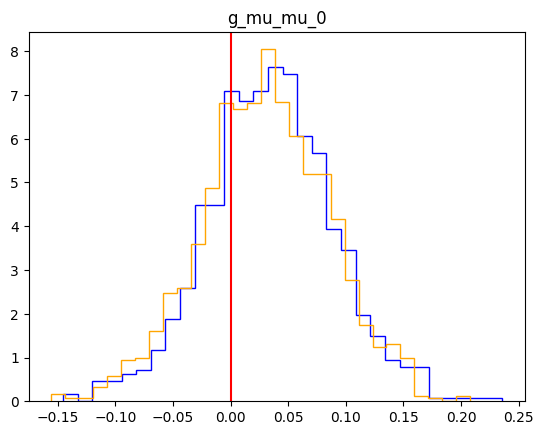

Warmup:   0%|          | 0/2200 [14:14, ?it/s]

{'g_mu_mu': array([0]), 'g_mu_std': array([0.25]), 'subj_mu': array([ 2.77138678e-04, -7.23860173e-02, -2.79016576e-01, -3.22068919e-03,
       -9.45903661e-02, -1.20283841e-01, -3.79332795e-01, -1.22717995e-01,
       -6.01701446e-02, -1.61986865e-01,  1.58972770e-01,  4.35029326e-01,
        7.41705544e-02,  1.76875915e-01,  4.55703941e-01,  1.07692257e-01,
        3.85682406e-01, -2.25180293e-01, -3.42812526e-02,  3.24394753e-01])}
g_mu_std
torch.Size([1000, 1, 1])
[0.25]
0.25


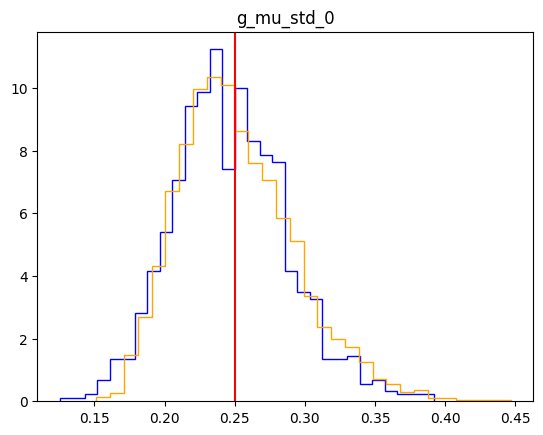

{'g_mu_mu': array([0]), 'g_mu_std': array([0.25]), 'subj_mu': array([ 2.77138678e-04, -7.23860173e-02, -2.79016576e-01, -3.22068919e-03,
       -9.45903661e-02, -1.20283841e-01, -3.79332795e-01, -1.22717995e-01,
       -6.01701446e-02, -1.61986865e-01,  1.58972770e-01,  4.35029326e-01,
        7.41705544e-02,  1.76875915e-01,  4.55703941e-01,  1.07692257e-01,
        3.85682406e-01, -2.25180293e-01, -3.42812526e-02,  3.24394753e-01])}
subj_mu
torch.Size([1000, 1, 20])
[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.0002771386780527433


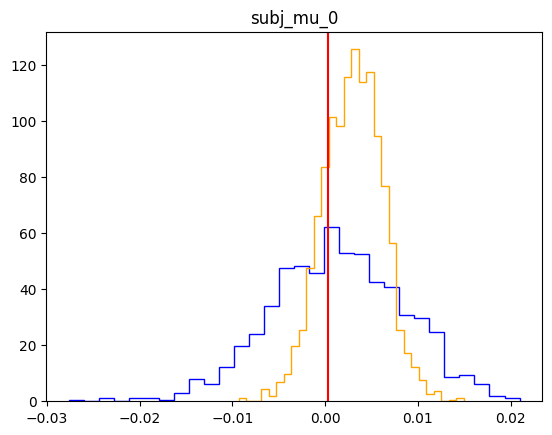

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.0723860173125497


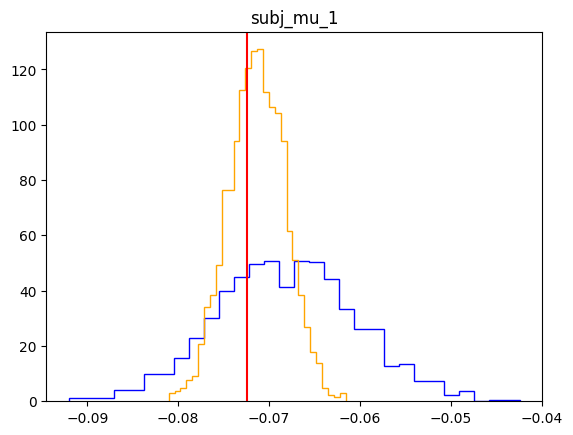

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.27901657576610356


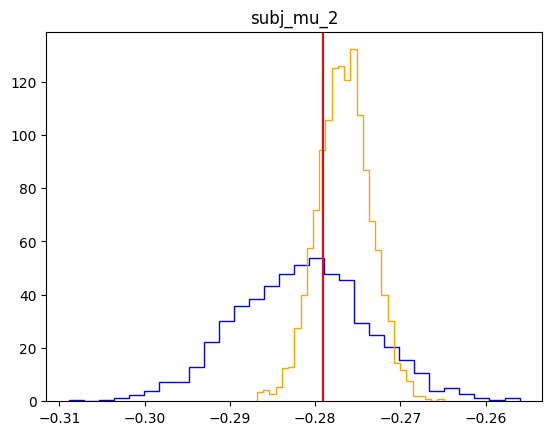

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.0032206891864485737


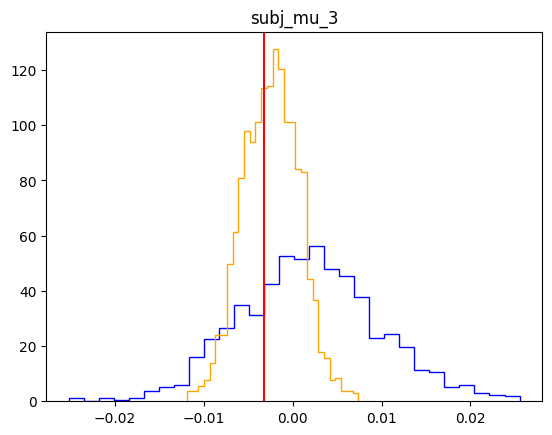

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.09459036605197953


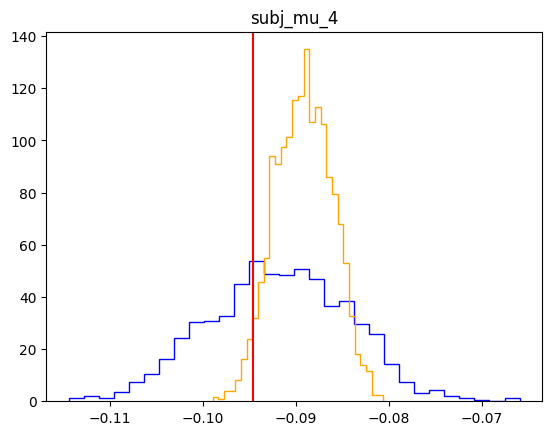

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.12028384071922597


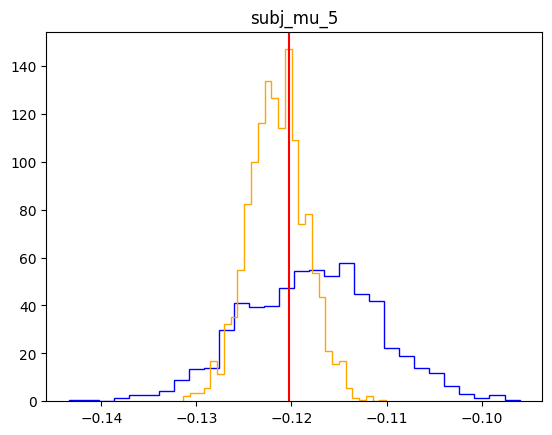

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.379332794698918


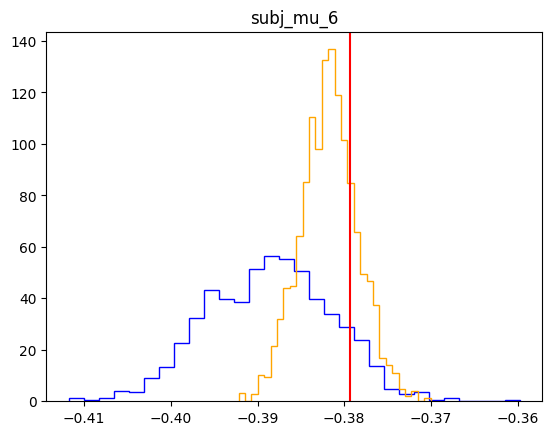

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.12271799530543662


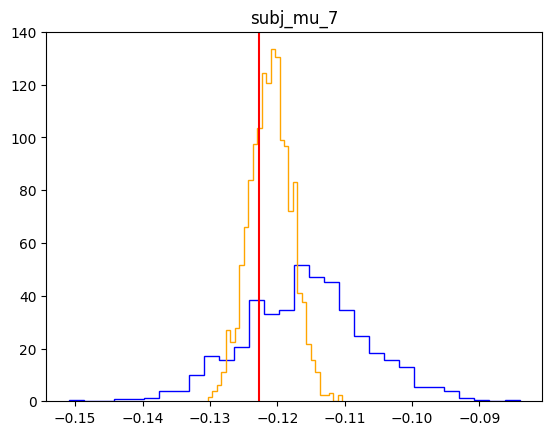

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.06017014462566819


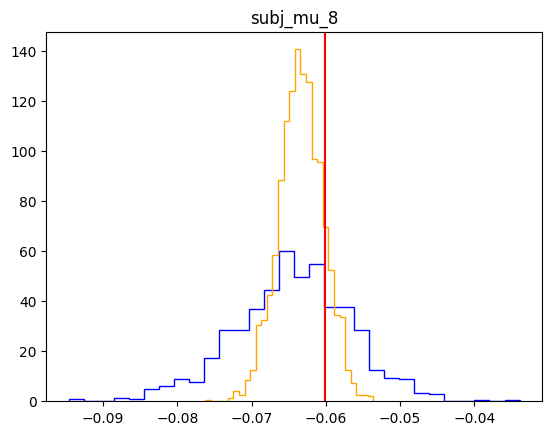

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.1619868650554009


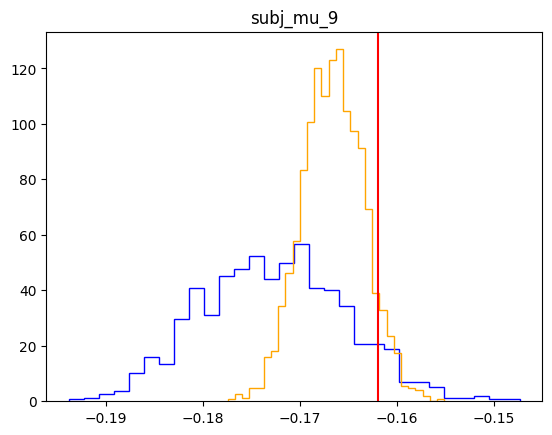

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.15897277006170793


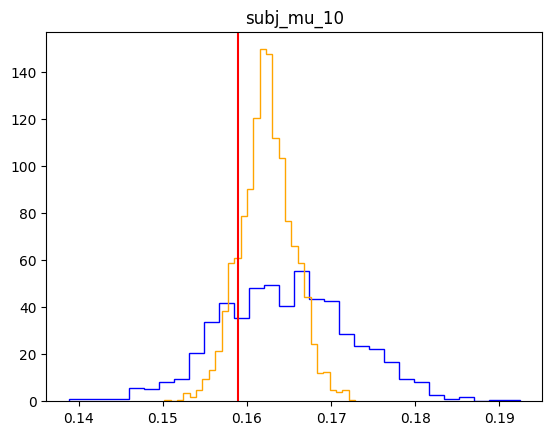

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.43502932632129415


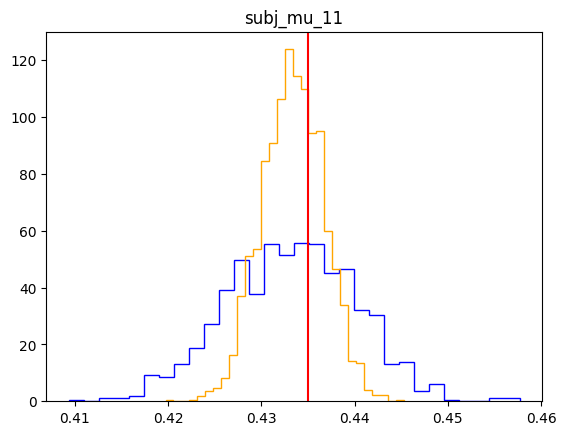

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.07417055442785082


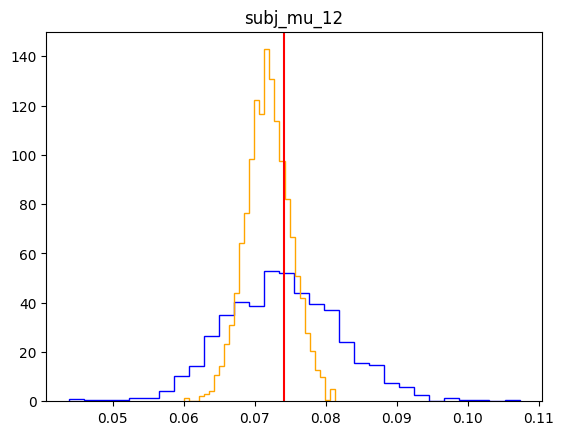

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.17687591546297207


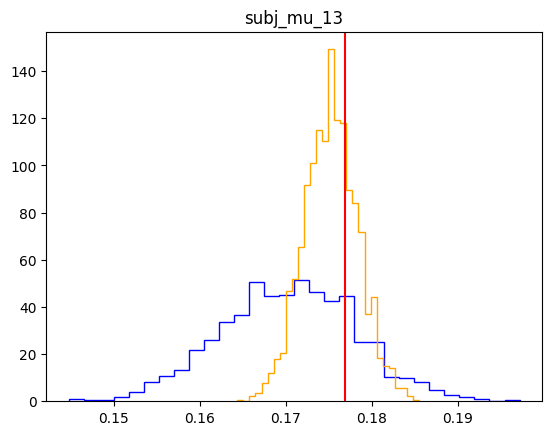

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.45570394077955917


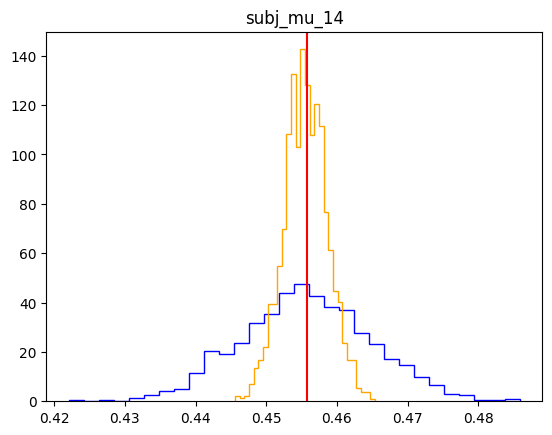

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.10769225737472315


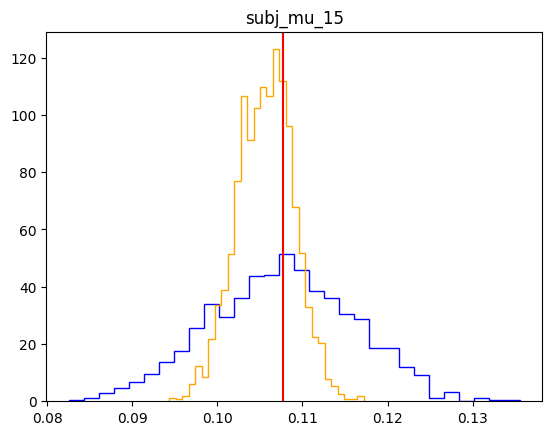

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.3856824063720217


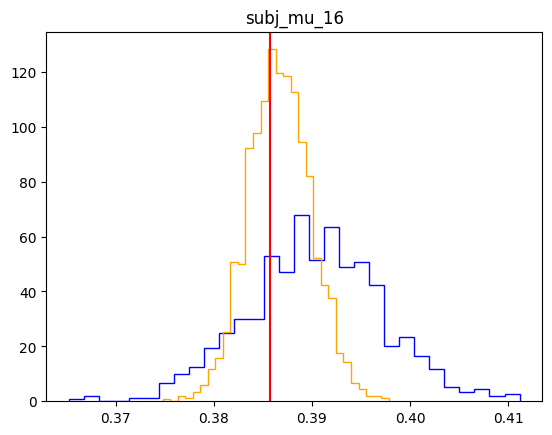

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.22518029285417218


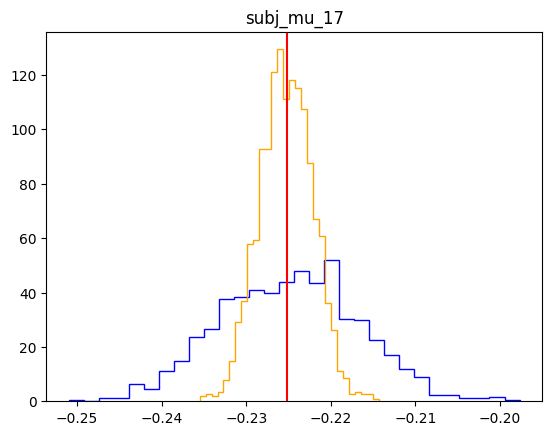

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.034281252594501335


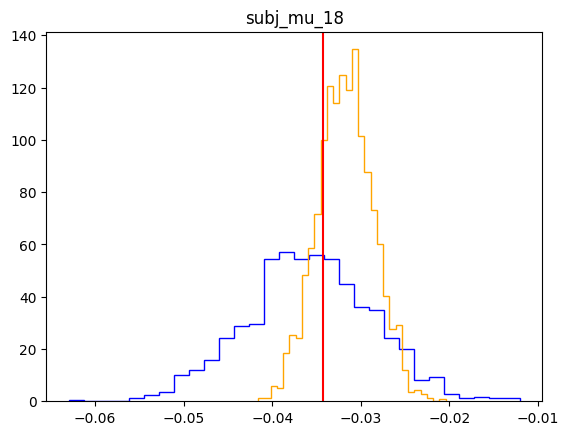

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.3243947530200125


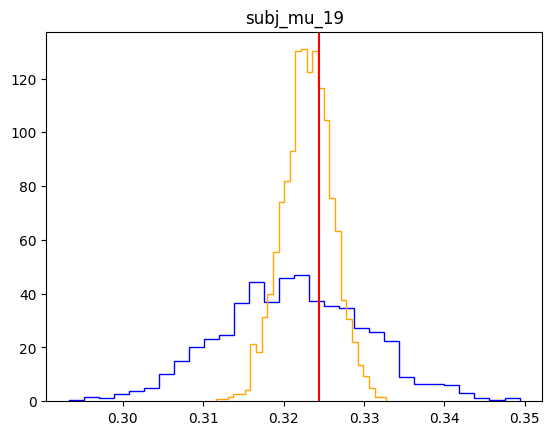

{'g_mu_mu': array([0]), 'g_mu_std': array([0.25]), 'subj_mu': array([ 2.77138678e-04, -7.23860173e-02, -2.79016576e-01, -3.22068919e-03,
       -9.45903661e-02, -1.20283841e-01, -3.79332795e-01, -1.22717995e-01,
       -6.01701446e-02, -1.61986865e-01,  1.58972770e-01,  4.35029326e-01,
        7.41705544e-02,  1.76875915e-01,  4.55703941e-01,  1.07692257e-01,
        3.85682406e-01, -2.25180293e-01, -3.42812526e-02,  3.24394753e-01])}
obs
torch.Size([1000, 1000, 20])


In [21]:
# tmp_dict = {'g_mu_mu': np.array(global_mean_mean, ndmin = 1),
#             'g_mu_std':np.array(global_mean_std, ndmin = 1),
#             'g_std_mu': np.array(global_std_mean, ndmin = 1),
#             'g_std_std': np.array(global_std_std, ndmin = 1),
#             'subj_std': np.array(subj_std, ndmin = 1),
#             'subj_mu': np.array(subj_mean, ndmin = 1),
#             }

tmp_dict = {'g_mu_mu': np.array(global_mean_mean, ndmin = 1),
            'g_mu_std': np.array(global_mean_std, ndmin = 1),
            'subj_mu': np.array(subj_mean, ndmin = 1),
            }

for key_ in svi_samples.keys():
    print(tmp_dict)
    #print(svi_samples[key_].numpy().shape[-1])
    print(key_)
    print(svi_samples[key_].shape)
    if key_ is not 'obs':
        for i in range(svi_samples[key_].numpy().shape[-1]):
            samples = svi_samples[key_].numpy().squeeze()
            hmc_samples = hmc_samples_new[key_].squeeze()
            shape_n = len(samples.shape)
            if shape_n == 2:
                tmp_samples = samples[:, i]
                tmp_hmc_samples = hmc_samples[:, i]
            else:
                tmp_samples = samples[:]
                tmp_hmc_samples = hmc_samples[:]
            plt.hist(tmp_samples, histtype = 'step', color = 'blue', bins = 30, density = True)
            plt.hist(tmp_hmc_samples, histtype = 'step', color = 'orange', bins = 30, density = True)
            print(tmp_dict[key_])
            print(tmp_dict[key_][i])
            plt.axvline(x = tmp_dict[key_][i], color = 'red')
            plt.title(key_ + '_' + str(i))
            plt.show()

In [ ]:
np.allclose(svi_samples["obs"][0, :].numpy(), svi_samples["obs"][1, :].numpy())

In [ ]:
plt.hist(svi_samples["obs"][2, :].numpy().squeeze())

In [ ]:
import scipy

global_mean_mean = scipy.stats.norm.rvs(loc = 0, scale = 10)
global_mean_std = scipy.stats.halfnorm.rvs(loc = 0, scale = 10)
global_std_mean = scipy.stats.halfnorm.rvs(loc = 0, scale = 10)
global_std_std = scipy.stats.halfnorm.rvs(loc = 0, scale = 10)

subj_std = scipy.stats.halfnorm.rvs(loc = global_std_mean, scale = global_std_std)
subj_mean = scipy.stats.norm.rvs(loc = global_mean_mean, scale = global_mean_std)
data = scipy.stats.norm.rvs(loc = subj_mean, scale = subj_std, size = 1000)

plt.hist(data)

In [83]:
tmp_dict = {'g_mu_mu': global_mean_mean,
            'g_mu_std':global_mean_std,
            'g_std_mu': global_std_mean,
            'g_std_std': global_std_std,
            'subj_std': subj_std,
            'subj_mu': subj_mean,
           }

In [ ]:
# Messengers

import pyro.poutine as poutine
from pyro.poutine.runtime import effectful

def make_log_joint(model):
    def _log_joint(cond_data, *args, **kwargs):
        conditioned_model = poutine.condition(model, data = cond_data)
        trace = poutine.trace(conditioned_model).get_trace(*args, **kwargs)
        return trace.log_prob_sum()
    return _log_joint


def make_trace(model):
    def _trace(cond_data, *args, **kwargs):
        conditioned_model = poutine.condition(model, data = cond_data)
        trace = poutine.trace(conditioned_model).get_trace(*args, **kwargs)
        return trace
    return _trace
    
scale_log_joint = make_log_joint(basic_hierarchical_model)
my_trace = make_trace(basic_hierarchical_model)


from pyro.poutine.trace_messenger import TraceMessenger
from pyro.poutine.condition_messenger import ConditionMessenger

def make_log_joint_2(model):
    def _log_joint(cond_data, *args, **kwargs):
        with TraceMessenger() as tracer:
            with ConditionMessenger(data=cond_data):
                model(*args, **kwargs)
        
        # print(tracer)
        trace = tracer.trace
        logp = 0.
        for name, node in trace.nodes.items():
            # print(name)
            if node["type"] == "sample":
                if node["is_observed"]:
                    assert node["value"] is cond_data[name]
                logp = logp + node["fn"].log_prob(node["value"]).sum()
        return logp
    return _log_joint

scale_log_joint_2 = make_log_joint_2(basic_hierarchical_model)
#print(scale_log_joint({"measurement": 9.5, "weight": 8.23}, 8.5))


tmp = scale_log_joint_2({'g_mu_mu': torch.tensor(hmc_samples['g_mu_mu'][0]), 
                         'g_mu_std': torch.tensor(hmc_samples['g_mu_std'][0]), 
                         'subj_mu': torch.tensor(hmc_samples['subj_mu'][0, :]),
                         'obs': torch_data}, 20, 1000, torch_data).numpy()

out = my_trace({'g_mu_mu': torch.tensor(hmc_samples['g_mu_mu'][0]), 
                'g_mu_std': torch.tensor(hmc_samples['g_mu_std'][0]), 
                'subj_mu': torch.tensor(hmc_samples['subj_mu'][0, :]),
                'obs': torch_data}, 20, 1000, None) #torch_data)




class LogJointMessenger(poutine.messenger.Messenger):

    def __init__(self, cond_data):
        self.data = cond_data

    # __call__ is syntactic sugar for using Messengers as higher-order functions.
    # Messenger already defines __call__, but we re-define it here
    # for exposition and to change the return value:
    def __call__(self, fn):
        def _fn(*args, **kwargs):
            with self:
                fn(*args, **kwargs)
                return self.logp.clone()
        return _fn

    def __enter__(self):
        self.logp = torch.tensor(0.)
        # All Messenger subclasses must call the base Messenger.__enter__()
        # in their __enter__ methods
        return super().__enter__()

    # __exit__ takes the same arguments in all Python context managers
    def __exit__(self, exc_type, exc_value, traceback):
        # Reset logp upon exit from the context
        self.logp = torch.tensor(0.)
        # All Messenger subclasses must call the base Messenger.__exit__ method
        # in their __exit__ methods.
        return super().__exit__(exc_type, exc_value, traceback)

    # _pyro_sample will be called once per pyro.sample site.
    # It takes a dictionary msg containing the name, distribution,
    # observation or sample value, and other metadata from the sample site.
    def _pyro_sample(self, msg):
        # Any unobserved random variables will trigger this assertion.
        # In the next section, we'll learn how to also handle sampled values.
        if msg["name"] in self.data:
            msg["value"] = self.data[msg["name"]]
            # Since we've observed a value for this site, we set the "is_observed" flag to True
            # This tells any other Messengers not to overwrite msg["value"] with a sample.
            msg["is_observed"] = True
            self.logp = self.logp + msg["fn"].log_prob(msg["value"]).sum()

with LogJointMessenger(cond_data={'g_mu_mu': torch.tensor(hmc_samples['g_mu_mu'][0]), 
                                  'g_mu_std': torch.tensor(hmc_samples['g_mu_std'][0]), 
                                  'subj_mu': torch.tensor(hmc_samples['subj_mu'][0, :]),
                                  'obs': torch_data}) as m:
    basic_hierarchical_model(20, 1000, None)
    print(m.logp.clone())
    
    
print('a')
scale_log_joint_manual = LogJointMessenger(cond_data={'g_mu_mu': torch.tensor(hmc_samples['g_mu_mu'][0]), 
                                                      'g_mu_std': torch.tensor(hmc_samples['g_mu_std'][0]), 
                                                      'subj_mu': torch.tensor(hmc_samples['subj_mu'][0, :]),
                                                      'obs': torch_data})

scale_log_joint_manual_specified = scale_log_joint_manual(basic_hierarchical_model)
scale_log_joint_manual_specified(20, 1000, None)

In [ ]:
log_joint_list = []
for i in range(2000):
    idx = np.random.choice(1000)
    tmp = scale_log_joint({'g_mu_mu': torch.tensor(hmc_samples['g_mu_mu'][idx]), 
                           'g_mu_std': torch.tensor(hmc_samples['g_mu_std'][idx]), 
                           'subj_mu': torch.tensor(hmc_samples['subj_mu'][idx, :])}, 20, 1000, torch_data).numpy()
    log_joint_list.append(tmp)
    
plt.hist(np.stack(log_joint_list))

In [ ]:
log_joint_list = []
for i in range(2000):
    idx = np.random.choice(1000)
    tmp = scale_log_joint({'g_mu_mu': torch.tensor(hmc_samples['g_mu_mu'][idx]), 
                           'g_mu_std': torch.tensor(hmc_samples['g_mu_std'][idx]), 
                           'subj_mu': torch.tensor(hmc_samples['subj_mu'][idx, :]),
                           'obs': torch_data}, 20, 1000, None).numpy()
    log_joint_list.append(tmp)
    
plt.hist(np.stack(log_joint_list))